In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
import keras
from keras import backend
from keras.models import load_model
import tensorflow as tf

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper

from matplotlib import pyplot as plt
import imageio

# Set the matplotlib figure size
plt.rc('figure', figsize = (12.0, 12.0))

# Set the learning phase to false, the model is pre-trained.
backend.set_learning_phase(False)
keras_model = load_model('models/cnnmodel.hdf5')

Using TensorFlow backend.


In [2]:
seed = 27

raw_data = pd.read_csv("input/train.csv")
train, validate = train_test_split(raw_data, 
                                   test_size=0.1,
                                   random_state = seed, 
                                   stratify = raw_data['label'])

# Split into input (X) and output (Y) variables
x_validation = validate.values[:,1:].reshape(4200,28,28, 1)
y_validation = validate.values[:,0]

In [3]:
tf.set_random_seed(1234)

if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")

# Retrieve the tensorflow session
sess =  backend.get_session()

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

# Evaluate the model's accuracy on the validation data used in training
x_validation = x_validation.astype('float32')
x_validation /= 255

pred = np.argmax(keras_model.predict(x_validation), axis = 1)
acc =  np.mean(np.equal(pred, y_validation))

print("The normal validation accuracy is: {}".format(acc))

The normal validation accuracy is: 0.9938095238095238


In [26]:
wrap = KerasModelWrapper(keras_model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate_np(x_validation, **fgsm_params)

adv_pred = np.argmax(keras_model.predict(adv_x), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, y_validation))

print("The adversarial validation accuracy is: {}".format(adv_acc))

[INFO 2019-03-27 13:12:28,082 cleverhans] Constructing new graph for attack FastGradientMethod


The adversarial validation accuracy is: 0.0988095238095238


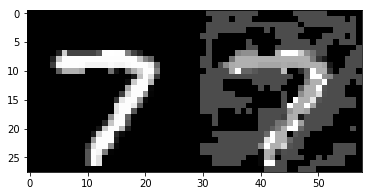

In [27]:
def stitch_images(images, y_img_count, x_img_count, margin = 2):
    
    # Dimensions of the images
    img_width = images[0].shape[0]
    img_height = images[0].shape[1]
    
    width = y_img_count * img_width + (y_img_count - 1) * margin
    height = x_img_count * img_height + (x_img_count - 1) * margin
    stitched_images = np.zeros((width, height, 3))

    # Fill the picture with our saved filters
    for i in range(y_img_count):
        for j in range(x_img_count):
            img = images[i * x_img_count + j]
            if len(img.shape) == 2:
                img = np.dstack([img] * 3)
            stitched_images[(img_width + margin) * i: (img_width + margin) * i + img_width,
                            (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

    return stitched_images

x_sample = x_validation[0].reshape(28, 28)
adv_x_sample = adv_x[0].reshape(28, 28)

adv_comparison = stitch_images([x_sample, adv_x_sample], 1, 2)

plt.imshow(adv_comparison)
plt.show()

In [28]:
normal_digit_img = x_sample.reshape(1, 28, 28, 1)
adv_digit_img = adv_x_sample.reshape(1, 28, 28, 1)

normal_digit_pred = np.argmax(keras_model.predict(normal_digit_img), axis = 1)
adv_digit_pred = np.argmax(keras_model.predict(adv_digit_img), axis = 1)

print('The normal digit is predicted to be a {}'.format(normal_digit_pred))
print('The adversarial example digit is predicted to be an {}'.format(adv_digit_pred))

The normal digit is predicted to be a [7]
The adversarial example digit is predicted to be an [2]
